# Train FFNN decocoder to predict location of animal from CA1 Hippocampus data

## Set up environment paths

In [88]:
import setup

setup.main()

%load_ext autoreload
%autoreload 2

Working directory:  /Users/facosta/Desktop/code/neurometry/neurometry
Directory added to path:  /Users/facosta/Desktop/code/neurometry
Directory added to path:  /Users/facosta/Desktop/code/neurometry/neurometry
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Imports

In [89]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
from torch import nn, optim
from torch.utils.data import DataLoader, TensorDataset

import neurometry.datasets.experimental as experimental

## Load neural activity & labels

In [87]:
expt_id = "34"
timestep_microsec = int(2e5)
vel_threshold = 10

neural_activity, labels = experimental.load_neural_activity(
    expt_id=expt_id, vel_threshold=vel_threshold, timestep_microsec=timestep_microsec
)

times_in_seconds = labels["times"] * 1e-6
angles = labels["angles"]

print(
    f"There are {neural_activity.shape[1]} neurons binned over {neural_activity.shape[0]} timesteps"
)

INFO: # - Found file at /Users/facosta/Desktop/code/neurometry/neurometry/data/binned/expt34_times_timestep200000_velthreshold_10.txt! Loading...
INFO: # - Found file at /Users/facosta/Desktop/code/neurometry/neurometry/data/binned/expt34_neural_activity_timestep200000_velthreshold_10.npy! Loading...


INFO: # - Found file at /Users/facosta/Desktop/code/neurometry/neurometry/data/binned/expt34_labels_timestep200000_velthreshold_10.txt! Loading...


There are 40 neurons binned over 2794 timesteps


In [73]:
# Set a fixed random seed for reproducibility
torch.manual_seed(0)


input_dim = neural_activity.shape[1]


# Define a simple feedforward neural network
class Decoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc_skip = nn.Linear(input_dim, 2).float()
        self.fc1 = nn.Linear(input_dim, 100).float()  # First hidden layer
        self.fc2 = nn.Linear(100, 100).float()  # Second hidden layer
        self.fc3 = nn.Linear(100, 100).float()
        self.fc4 = nn.Linear(100, 40).float()
        self.fc_out = nn.Linear(40, 2).float()

    def forward(self, x):
        x_skip = F.relu(self.fc_skip(x))
        x = x.float()
        x = F.relu(self.fc1(x))  # Apply ReLU activation function after first layer
        x = F.relu(self.fc2(x))  # Apply ReLU activation function after second layer
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        return F.tanh(
            self.fc_out(x) + x_skip
        )  # No activation function after final layer (for regression task)

In [74]:
device = torch.device(
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using device: {device}")

# Create an instance of the network
decoder = Decoder().to(device)

# Use mean squared error loss for regression
criterion = nn.MSELoss()

# use adam optimizer
optimizer = optim.Adam(decoder.parameters(), lr=0.01)

scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)

Using device: mps


In [75]:
angles_radians = angles * np.pi / 180
cos_sin_angles = np.vstack((np.cos(angles_radians), np.sin(angles_radians))).T

In [77]:
# Assume we have some training data in input_data (100-dimensional input) and target_data (2-dimensional output)
input_data = torch.from_numpy(neural_activity).float().to(device)
target_data = torch.from_numpy(cos_sin_angles).float().to(device)

# Split data into training and validation sets (80-20 split)
train_size = int(0.8 * len(input_data))
val_size = len(input_data) - train_size

train_data = TensorDataset(input_data[:train_size], target_data[:train_size])
val_data = TensorDataset(input_data[train_size:], target_data[train_size:])

# Create DataLoaders from your datasets
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
val_loader = DataLoader(val_data, batch_size=64, shuffle=True)

In [78]:
num_epochs = 150

import copy

# Arrays to keep track of losses
train_losses = []
val_losses = []

lowest_val_loss = 10000
# Train the network
for epoch in range(num_epochs):  # Loop over the dataset multiple times
    # Training phase
    decoder.train()
    running_loss = 0.0
    for inputs, targets in train_loader:
        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = decoder(inputs)

        # Compute loss
        loss = criterion(outputs, targets)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    epoch_train_loss = running_loss / len(train_loader)
    train_losses.append(epoch_train_loss)
    print(f"Epoch {epoch+1}, Training Loss: {epoch_train_loss}")

    # Validation phase
    decoder.eval()
    with torch.no_grad():
        running_loss = 0.0
        for inputs, targets in val_loader:
            outputs = decoder(inputs)
            loss = criterion(outputs, targets)
            running_loss += loss.item()

        epoch_val_loss = running_loss / len(val_loader)
        val_losses.append(epoch_val_loss)
        print(f"Epoch {epoch+1}, Validation Loss: {epoch_val_loss}")

        if epoch == 1 or epoch_val_loss < lowest_val_loss:
            lowest_val_loss = epoch_val_loss
            best_model = copy.deepcopy(decoder)
    scheduler.step()

print("Finished Training")

Epoch 1, Training Loss: 0.22401070275477
Epoch 1, Validation Loss: 0.2023737629254659
Epoch 2, Training Loss: 0.08336301477892058
Epoch 2, Validation Loss: 0.1639416217803955
Epoch 3, Training Loss: 0.06474006058914321
Epoch 3, Validation Loss: 0.15393091241518655
Epoch 4, Training Loss: 0.054829552876097816
Epoch 4, Validation Loss: 0.16894966198338401
Epoch 5, Training Loss: 0.05206234763775553
Epoch 5, Validation Loss: 0.13917478919029236
Epoch 6, Training Loss: 0.045386929863265583
Epoch 6, Validation Loss: 0.13652707636356354
Epoch 7, Training Loss: 0.04023012625319617
Epoch 7, Validation Loss: 0.13786159538560444
Epoch 8, Training Loss: 0.037251912536365644
Epoch 8, Validation Loss: 0.1397169770465957
Epoch 9, Training Loss: 0.034720211529306
Epoch 9, Validation Loss: 0.13535428626669777
Epoch 10, Training Loss: 0.033476796107632774
Epoch 10, Validation Loss: 0.1403060265713268
Epoch 11, Training Loss: 0.03297266374741282
Epoch 11, Validation Loss: 0.1417232801516851
Epoch 12, Tr

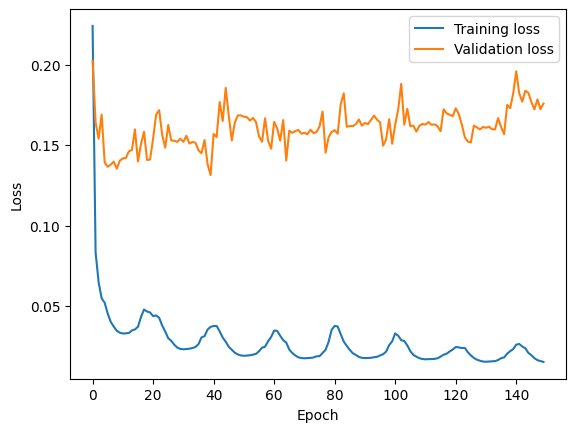

In [79]:
# Plot training and validation losses
plt.plot(train_losses, label="Training loss")
plt.plot(val_losses, label="Validation loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [80]:
val_neural_activity = input_data[train_size:]
val_angles = target_data[train_size:].cpu().numpy()

decoder.eval()
decoded_angles = decoder(val_neural_activity).detach().cpu().numpy()

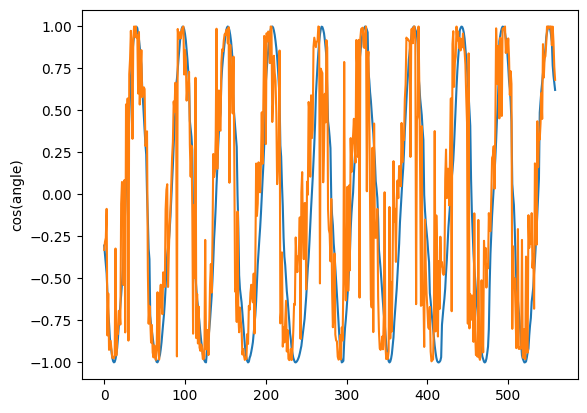

In [81]:
plt.plot(val_angles[:, 0])
plt.plot(decoded_angles[:, 0])
plt.ylabel("cos(angle)");

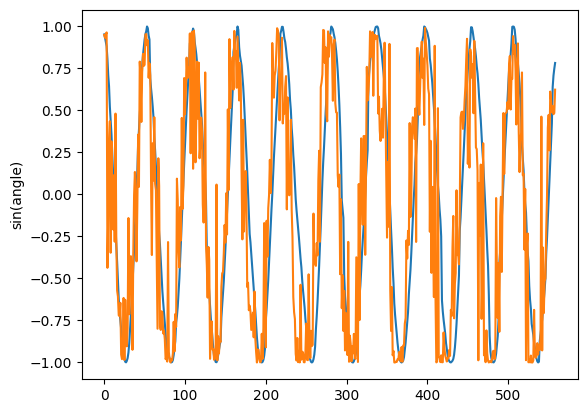

In [82]:
plt.plot(val_angles[:, 1])
plt.plot(decoded_angles[:, 1])
plt.ylabel("sin(angle)");

In [56]:
dec_theta = np.arctan2(decoded_angles[:, 1], decoded_angles[:, 0])
val_theta = np.arctan2(val_angles[:, 1], val_angles[:, 0])

In [85]:
dec_theta = decoder(torch.tensor(neural_activity).float()).detach().cpu().numpy()

RuntimeError: Placeholder storage has not been allocated on MPS device!

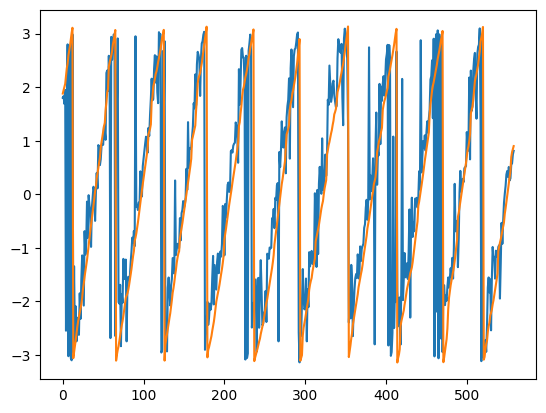

In [57]:
plt.plot(dec_theta)
plt.plot(angles)

## Bayesian Decoder (GPT4) -- Fix

In [10]:
import numpy as np
from scipy.stats import poisson

# Simulated data
num_neurons = 10
num_bins = 100
num_positions = 360  # 360 degrees
spike_counts = np.random.poisson(5, (num_neurons, num_bins))
actual_positions = np.random.randint(0, num_positions, num_bins)
place_fields = np.random.rand(num_neurons, num_positions)

# Prior probability
prior = np.ones(num_positions) / num_positions

# Bayesian decoding
decoded_positions = []
for t in range(num_bins):
    likelihood = np.prod(
        [
            poisson.pmf(spike_counts[n, t], place_fields[n, :])
            for n in range(num_neurons)
        ],
        axis=0,
    )
    posterior = likelihood * prior
    posterior /= np.sum(posterior)
    decoded_position = np.argmax(posterior)
    decoded_positions.append(decoded_position)

# Evaluation
mse = np.mean((np.array(decoded_positions) - actual_positions) ** 2)
print(f"Mean Squared Error: {mse}")

Mean Squared Error: 18631.91
